In [1]:
import os, pickle, time, gzip, sys, torch
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from pymatgen.core import Element, Composition
from src.feature import composition_to_feature, LigandTemplateReference
from src.utils import composit_parser, MetalElements, LigandElements, ActiveElements
from src.utils import heat_tempearture_norm, heat_tempearture_denorm, heat_time_norm, heat_time_denorm
from src.utils import parse_cvae_output_v0, parse_rxn_ids, sort_precursor_by_target_element
from src.data import ReactionGraphDataset
from src.networks import GraphCVAE

# GCVAE


### updater

In [2]:
output_root = '/home/jhyang/WORKSPACES/MODELS/isyn/GCVAE'
for dir in os.listdir(output_root):
    output_path = os.path.join(output_root, dir)
    enc = pickle.load(open(f'{output_path}/model_encoder.model', 'rb'))
    dec = pickle.load(open(f'{output_path}/model_decoder.model', 'rb'))

    input_dim = enc['model_param']['input_dim']
    latent_dim = int(enc['model_param']['output_dim'] * 0.5)
    condition_dim = dec['model_param']['input_dim'] - latent_dim
    edge_dim = enc['model_param']['edge_dim']
    output_dim = dec['model_param']['output_dim']
    hidden_dim = enc['model_param']['hidden_dim']
    hidden_layers = enc['model_param']['hidden_layers']
    model = GraphCVAE(input_dim = input_dim,
                      latent_dim = latent_dim,
                      condition_dim = condition_dim,
                      edge_dim = edge_dim,
                      output_dim = output_dim,
                      encoder_hidden_dim = hidden_dim,
                      encoder_hidden_layers = hidden_layers,
                      decoder_hidden_dim = hidden_dim,
                      decoder_hidden_layers = hidden_layers,
                      batch_norm = True,
                      dropout = 0)
    model.encoder.load_state_dict({k:torch.from_numpy(v) for k,v in enc['state_dict'].items()})
    model.decoder.load_state_dict({k:torch.from_numpy(v) for k,v in dec['state_dict'].items()})
    model.save(output_path, 'best')

FileNotFoundError: [Errno 2] No such file or directory: '/home/jhyang/WORKSPACES/MODELS/isyn/GCVAE/cgcnn_convolution_m16.128.4_batch_0256/model_encoder.model'

## analysis

In [3]:
with open('../data/info_target_distribution.pkl','rb') as f:
    target_network = pickle.load(f)

In [4]:
output_path = '/home/jhyang/WORKSPACES/MODELS/isyn/GCVAE/composit_convolution_m08.128.2_batch_0064'
feat_type = output_path.split('/')[-1].split('_')[0]
PR = LigandTemplateReference(feat_type=feat_type)
DS = ReactionGraphDataset(feat_type=feat_type)
DS.from_file('../data/screened_unique_reaction_ss.pkl.gz',
#             heat_temp_fnc = lambda x: x['heat_temp_med'],
#             heat_time_fnc = lambda x: x['heat_time_med'],
             )

with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    unique_reaction = pickle.load(f)
id_to_idx = {d['id_reaction']:i for i, d in enumerate(unique_reaction)}

model = GraphCVAE(1,1,1,1).load(output_path, prefix='best', requires_grad=False)
valid_output = pickle.load(open(f'{output_path}/output.valid.pkl','rb'))
test_output = pickle.load(open(f'{output_path}/output.test.pkl','rb'))

In [32]:
def get_likely_list(target, metals, preds, pred_has, precursor_reference):
    ele_mask = [precursor_reference.get_weight(e).reshape(-1) > 0 for e in target.keys() if e not in MetalElements]
    sorted_probs = []
    for metal, prob in zip(metals, preds):
        step_probs = []
        idxs = np.argsort(prob)[::-1]
        p_sum = 0
        for idx in idxs:
            p = prob[idx]
            if p_sum > 0.99 or p < 0.01:
                break
            p_sum += p
            step_probs.append([p, idx])
        if metal == 'none':
            step_probs = [[1 - pred_has, precursor_reference._ligand_str.index('')]] + [[_p * pred_has, _i] for _p,_i in step_probs]
        sorted_probs.append(step_probs)

    likelies = []
    l_sum = 0
    for comb in product(*sorted_probs):
        if np.sum([c[0] for c in comb]) < 0.1:
            continue
        labels = [c[1] for c in comb]
        skip = False
        if len(ele_mask) != 0:
            label_mask = np.zeros_like(ele_mask[0], dtype=bool)
            label_mask[labels] = True
            for _mask in ele_mask:
                if (_mask & label_mask).sum() == 0:
                    skip = True
                    break
        if skip:
            continue
        l = np.prod([c[0] for c in comb])
        if l < 0.001:
            continue
        p = []
        for metal, label in zip(metals, labels):
            if metal == 'none' and label == precursor_reference._ligand_str.index(''):
                continue
            p_comp = precursor_reference.get_info(metal, label)['precursor_comp']
            p.append(Composition(p_comp).get_integer_formula_and_factor()[0])
        likelies.append((tuple(p), l))
        l_sum += l
    return [(l[0], l[1]/l_sum) for l in sorted(likelies, key=lambda x: x[1], reverse=True)]

def get_sampling_result(model, feat_type, target_comp, heat_temp, heat_time, n_sample=1000):
    LTR = LigandTemplateReference(feat_type = feat_type)
    RGDS = ReactionGraphDataset(feat_type = feat_type, base_info_attrs = [])
    new_data = [{'target_comp':target_comp, 'heat_temp':t1, 'heat_time':t2} for t1, t2 in product(heat_temp, heat_time)]
    RGDS.from_dataset(new_data, heat_temp_fnc=lambda x: x['heat_temp'], heat_time_fnc=lambda x: x['heat_time'], extend_dataset=False)

    feat, info = RGDS.cfn(RGDS)
    condition = torch.hstack([feat['meta_feat'], feat['condition_feat'][feat['rxn_id']]])
    edge_attr = feat['edge_attr']
    edge_index = feat['edge_index']
    is_last = np.hstack([feat['rxn_id'][1:] != feat['rxn_id'][:-1], [True]])

    with torch.no_grad():
        sampling_output, z = model.sampling(n=n_sample, edge_index=edge_index, edge_attr=edge_attr, 
                                            condition=condition)

    sampling_output = torch.stack(sampling_output)
    probs = torch.nn.functional.softmax(sampling_output[..., 1:] + ((feat['weight'] > 0).float() - 1) * 5000, -1).cpu().numpy()
    has_last = 1/(1 + np.exp(-sampling_output[:, is_last, 0].cpu().numpy())).T

    results = []
    for i, meta in enumerate(info):
        m = feat['rxn_id'] == i
        result = {'target_comp':Composition(meta['target_comp']).get_integer_formula_and_factor()[0],
                'heat_temp': meta['heat_temp'], 
                'heat_time': meta['heat_time'],
                'tree':{}
                }
        for prob, last in zip(probs[:, m], has_last[i]):
            likelies = get_likely_list(meta['target_comp'], meta['metals'], prob, last, LTR)
            for key, likely in likelies:
                if key not in result['tree'].keys():
                    result['tree'][key] = 0
                result['tree'][key] += likely / n_sample
        result['tree'] = {k:v for k,v in sorted(result['tree'].items(), key=lambda x: x[1], reverse=True) if v > 0.001}
        results.append(result)
    return results, z

In [47]:
heat_temp = np.linspace(500, 2000, 8)
heat_time = np.linspace(10, 50, 5)
sampling_result, z = get_sampling_result(
                        model, feat_type, 
                        target_comp={'Zn':1,'Fe':2,'O':4},
                        heat_temp = heat_temp, heat_time = [10])


Text(0, 0.5, 'Probability')

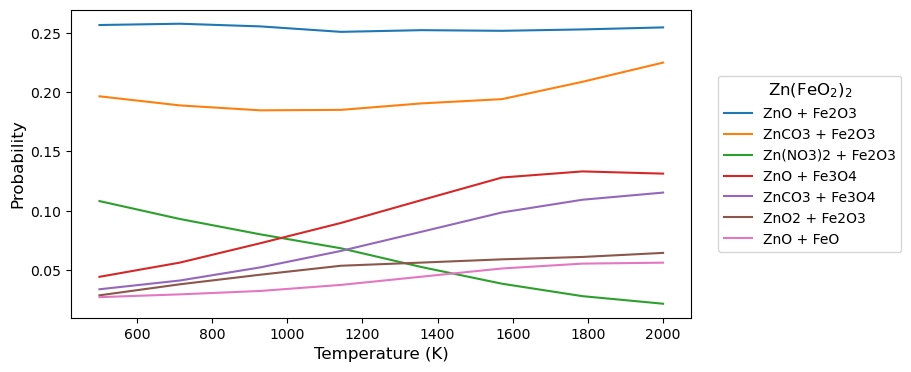

In [70]:
transposed = {}
for result in sampling_result:
#    print(result['heat_temp'])
    for k,v in result['tree'].items():
        if v < 0.01: break
#        print(f'\t{v:.4f} : {k}')
        if k not in transposed:
            transposed[k] = []
for result in sampling_result:
    remove = []
    for k in transposed.keys():
        if k not in result['tree'].keys():
            remove.append(k)
            continue
        transposed[k].append(result['tree'][k])
    [transposed.pop(k) for k in remove]
    remove = []

f, ax = plt.subplots(1,1,figsize=(8,4))
for k, v in transposed.items():
    if np.max(v) < 0.05: continue
    ax.plot(heat_temp, v, label=' + '.join(k))
ax.legend(loc='center right', bbox_to_anchor=(1.35,0.5), fontsize=10, 
          title='Zn(FeO$_2$)$_2$', title_fontsize=12)
ax.set_xlabel('Temperature (K)', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)

In [81]:
torch.stack(z).numpy()[:, :3, :].shape

(1000, 3, 8)

In [46]:
def get_neighbors(id):
    out = target_network[id]
    if isinstance(out, int):
        return get_neighbors(out)
    else:
        return out
    
nbrs = get_neighbors(11)
for rxn_id, dist in sorted(zip(nbrs['id_reaction'], nbrs['dist']), key=lambda x: x[1]):
    if rxn_id not in id_to_idx.keys():
        continue
    nbr = unique_reaction[id_to_idx[rxn_id]]
    heat_temp = np.hstack([t['raw'] for t in nbr['heat_temp']])
    heat_time = np.hstack([t['raw'] for t in nbr['heat_time']])
    target, precursor = sort_precursor_by_target_element(nbr['target_comp'], nbr['precursor_comp'])
    print(f'{rxn_id}\t{dist:.4f}    {target:25s} | ',
          '{:7.0f}{:7.0f}{:7.0f} | '.format(np.min(heat_temp), np.max(heat_temp), np.median(heat_temp)) if len(heat_temp) != 0 else ' '*24, 
          '{:4.0f}{:4.0f}{:4.0f} | '.format(np.min(heat_time), np.max(heat_time), np.median(heat_time)) if len(heat_time) != 0 else ' '*15, 
          ' '.join([f'{p:8s}' for p in precursor]))

11	0.0000    Zn(FeO2)2                 |      773   1673   1273 |     0  30   6 |  ZnO      Fe2O3   
12	0.0000    Zn(FeO2)2                 |                                           ZnO      FeO2    
13	0.0000    Zn(FeO2)2                 |     1373   1548   1461 |     0   4   2 |  ZnO      Fe3O4   
14	0.0000    Zn(FeO2)2                 |     1373   1373   1373 |     2   2   2 |  Zn(HO)2  Fe2O3   
15	0.0000    Zn(FeO2)2                 |      823    823    823 |     2   2   2 |  Zn(NO3)2 Fe(NO3)2
10000	0.0080    Zn383(Fe127O256)13        |     1323   1473   1398 |    12  12  12 |  ZnO      Fe2O3   
18807	0.0102    ZnFe5O8                   |     1023   1423   1348 |     5   5   5 |  ZnO      Fe3O4   
28415	0.0106    Zn2Fe2O5                  |      873   1173   1073 |     4   4   4 |  ZnO      Fe3O4   
26988	0.0261    Zn(Fe7O10)2               |     1173   1223   1198 |     6   6   6 |  ZnO      Fe2O3   
26987	0.0331    ZnFe29O40                 |     1173   1223   1198 |     6   6 

In [197]:
results[5]

{'target_comp': 'LiCoO2',
 'heat_temp': 1400,
 'heat_time': 4,
 'tree': {('Li2CO3', 'CoO'): 0.11558497360147671,
  ('LiCO3', 'CoO'): 0.10716079554772298,
  ('Li2CO3', 'Co2O3'): 0.06773817342878902,
  ('LiCO3', 'Co2O3'): 0.06411707309528757,
  ('Li2O', 'CoO'): 0.06409109250381621,
  ('Li2CO3', 'Co3O4'): 0.0556370131946991,
  ('LiCO3', 'Co3O4'): 0.05276542915832153,
  ('Li2CO3', 'CoCO3'): 0.04397910251720242,
  ('LiCO3', 'CoCO3'): 0.041140815090998255,
  ('Li2O', 'Co2O3'): 0.03849708454983622,
  ('Li2O2', 'CoO'): 0.03805426375253876,
  ('Li2O', 'Co3O4'): 0.03154064481800199,
  ('LiHO', 'CoO'): 0.03026792270910696,
  ('Li2O', 'CoCO3'): 0.025422604074125964,
  ('Li2O2', 'Co2O3'): 0.02274946643203363,
  ('Li2O2', 'Co3O4'): 0.01876067768721525,
  ('LiHO', 'Co2O3'): 0.017734992005209473,
  ('LiNO3', 'CoO'): 0.015170587748139135,
  ('Li2O2', 'CoCO3'): 0.014748451360776127,
  ('LiHO', 'Co3O4'): 0.014745946529760016,
  ('Li2CO3', 'Co(NO3)2'): 0.012026370218894026,
  ('LiHO', 'CoCO3'): 0.01148864

In [112]:
np.where(LTR._weight[ActiveElements.index('Li')])


-12.779264


# from VAE_test

## classification

In [60]:
record = {}
root = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_test/cls'
for dir in os.listdir(os.path.join(root)):
    path = path = os.path.join(root, dir)
    if len(os.listdir(path)) < 2:
        continue
#        [print(fn) for fn in os.listdir(path)]
    model = dir.split('_')[0]
    if model not in record.keys():
        record[model] = []
    record[model].append([])
    for ds in ['valid','test']:
        output = pickle.load(open(os.path.join(path, f'output.{ds}.pkl'), 'rb'))
        pred, label = output['pred'].argmax(1), output['label']
        f1i = f1_score(label, pred, average='micro')
        f1a = f1_score(label, pred, average='macro')
        record[model][-1].extend([f1i, f1a])
        rxn = {}
        if model != 'fcnn':
            i = 0
            for info in output['info']:
                id = info['id']
                rxn[id] = [[], [], 0]
                for j in range(len(info['precursor_comp'])):
                    rxn[id][0].append(output['label'][i+j])
                    rxn[id][1].append(output['pred'][i+j].argmax())
                i += len(info['precursor_comp'])
                metals = {}
                for precursor_comp in info['precursor_comp']:
                    for ele in precursor_comp.keys():
                        if ele not in MetalElements:
                            continue
                        if ele not in metals.keys():
                            metals[ele] = 0
                        metals[ele] += 1
                rxn[id][-1] = np.max(list(metals.values()))
            result = [np.sum((np.array(l) != np.array(p))) == 0 for l, p, m in rxn.values() if m == 1]
        else:
            rxn = {}
            for info, l, p in zip(output['info'], output['label'], output['pred'].argmax(1)):
                id = info['id']
                if id not in rxn.keys():
                    rxn[id] = [[], [], {}]
                rxn[id][0].append(l)
                rxn[id][1].append(p)
                for ele in info['precursor_comp'].keys():
                    if ele not in MetalElements:
                        continue
                    if ele not in rxn[id][2].keys():
                        rxn[id][2][ele] = 0
                    rxn[id][2][ele] += 1
            result = [np.sum((np.array(l) != np.array(p))) == 0 for l, p, m in rxn.values() if np.max(list(m.values())) == 1]
        record[model][-1].append(np.mean(result))

In [61]:
#record = pickle.load(open('../dump/vae_test_cls.pkl','rb'))
for k,v in record.items():
    j = np.array(v).T[0].argmax()
    print(k, np.array(v)[j])
#pickle.dump(record, open('../dump/vae_test_cls.pkl','wb'))

fcnn [0.91305179 0.44238276 0.80159091 0.91160586 0.47782328 0.79559505]
convolution [0.91139563 0.49212555 0.79318182 0.91336934 0.51541477 0.80023184]


## regression 

In [121]:

pstr_to_label = {p['precursor_str']:i for i, p in enumerate(unique_precursor)}
legacy_active_elements = sorted(MetalElements + LigandElements, key=lambda x: Element(x).number)

def legacy_composit_feature(comp):
    v = np.zeros(len(legacy_active_elements))
    div = np.sum(list(comp.values()))
    for e, f in comp.items():
        v[legacy_active_elements.index(e)] = f / div
    return v

ref = np.array([legacy_composit_feature(p['precursor_comp'], ) for p in unique_precursor])

root = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_test/reg'
record = {}
for dir in os.listdir(os.path.join(root)):
    path = path = os.path.join(root, dir)
    if len(os.listdir(path)) < 2:
        continue
#        [print(fn) for fn in os.listdir(path)]
    model = dir.split('_')[0]
    if model not in record.keys():
        record[model] = []
    record[model].append([])
    for ds in ['valid','test']:
        output = pickle.load(open(os.path.join(path, f'output.{ds}.pkl'), 'rb'))
        pred = np.square(ref[..., np.newaxis] - output['pred'].T[np.newaxis, ...]).sum(1).argmin(0)
        if 'fcnn' in dir:
            label = np.array([pstr_to_label[composit_parser(o['precursor_comp'])] for o in output['info']])
        else:
            label = [np.array([pstr_to_label[composit_parser(p)] for p in o['precursor_comp']]) for o in output['info']]

        f1i = f1_score(np.hstack(label), pred, average='micro')
        f1a = f1_score(np.hstack(label), pred, average='macro')
        record[model][-1].extend([f1i, f1a])
        if 'fcnn' in dir:
            rxn = {}
            for info, p, l in zip(output['info'], pred, label):
                id = info['id']
                if id not in rxn.keys():
                    rxn[id] = [[], []]
                rxn[id][0].append(l)
                rxn[id][1].append(p)
            result = [np.sum((np.array(l) != np.array(p))) == 0 for l, p in rxn.values()]
            record[model][-1].append(np.mean(result))
        else:
            rxn = []
            i = 0
            for l in label:
                j = i + len(l)
                rxn.append(np.sum(l != pred[i:j]) == 0)
                i = j
            record[model][-1].append(np.mean(rxn)) 

In [125]:
for k,v in record.items():
    j = np.array(v).T[0].argmax()
    print(k, np.array(v)[j])


convolution [0.50064608 0.258432   0.2294353  0.45767815 0.27659369 0.1958684 ]
attention [0. 0. 0. 0. 0. 0.]
fcnn [0.05808244 0.01478776 0.00022232 0.06546225 0.01584401 0.        ]


# VAE_FCNN

In [67]:
root = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE_FCNN'
record = {}
outputs = {}
c = 0
for dir in os.listdir(os.path.join(root)):
    path = path = os.path.join(root, dir)
    if len(os.listdir(path)) < 2:
        continue
#        [print(fn) for fn in os.listdir(path)]
    model = dir.split('_')[0]
    if model not in record.keys():
        record[model] = []
    record[model].append([])
    outputs[dir] = {}
    for ds in ['valid','test']:
        outputs[dir][ds] = pickle.load(open(os.path.join(path, f'best.output.{ds}.pkl'), 'rb'))
        c += 1

In [76]:
def legacy_ligand_feat(comp):
    v = np.zeros(len(LigandElements)+1)
    for e, n in comp.items():
        if e in MetalElements:
            v[0] = 1
        else:
            v[LigandElements.index(e)+1] = 1
    return v

def ligand_feat_to_string(vecs):
    strs = [''.join([f'{v:.0f}' for v in vec]) for vec in vecs]
    return strs

legacy_ligand_feat_ref = np.vstack([np.array(list(s)).astype(int) for s in np.unique([''.join([f'{n:.0f}' for n in legacy_ligand_feat(p['precursor_comp'])]) for p in unique_precursor])])
legacy_ligand_label = ligand_feat_to_string(legacy_ligand_feat_ref)
ligand_feat_str_to_label = {s:i for i,s in enumerate(legacy_ligand_label)}

record = {}
for dir, ds0 in outputs.items():
    model = dir.split('_')[0]
    if model not in record.keys():
        record[model] = []
    record[model].append([])
    for ds, output in ds0.items():
        pred = np.square(legacy_ligand_feat_ref[..., np.newaxis, ] - output['pred'].T[np.newaxis, ...]).sum(1).argmin(0)
        label = np.array([ligand_feat_str_to_label[s] for s in ligand_feat_to_string(output['input'])])
        f1 = f1_score(label, pred, average='micro')
        record[model][-1].append(f1)
        rxn = {}
        for info, p, l in zip(output['info'], pred, label):
            id = info['id']
            if id not in rxn.keys():
                rxn[id] = [[], [],{}]
            rxn[id][0].append(l)
            rxn[id][1].append(p)
            for ele in info['precursor_comp'].keys():
                if ele not in MetalElements:
                    continue
                if ele not in rxn[id][2].keys():
                    rxn[id][2][ele] = 0
                rxn[id][2][ele] += 1
        result = [np.sum((np.array(l) != np.array(p))) == 0 for l, p, m in rxn.values() if np.max(list(m.values())) == 1]
        record[model][-1].append(np.mean(result))

In [77]:
for k,v in record.items():
    print(k, v[np.argmax(v, 0)[0]])

oliynyk [0.9066430693382214, 0.7970687711386697, 0.8990975318038491, 0.7842987804878049]
mat2vec [0.906832690727514, 0.797294250281849, 0.9014896161791889, 0.788109756097561]
magpie [0.9077175905442134, 0.7988726042841037, 0.8927911275415896, 0.7648628048780488]
matscholar [0.9043044055369446, 0.7851183765501691, 0.8964879852125692, 0.7736280487804879]
elemnet [0.9086656974906769, 0.8, 0.899641187343699, 0.786204268292683]
megnet16 [0.9030402629416598, 0.7857948139797069, 0.8969229096444493, 0.7778201219512195]
cgcnn [0.9049364768345869, 0.786696730552424, 0.8971403718603893, 0.7808689024390244]
active [0.9059477909108148, 0.7952649379932356, 0.901272153963249, 0.7915396341463414]


In [73]:
result = [np.sum((np.array(l) != np.array(p))) == 0 for l, p, m in rxn.values() if np.max(list(m.values())) == 1]
np.mean(result)


0.7439024390243902

In [43]:
output['info']

[{'id': 49,
  'raw_id': 38563,
  'year': 2020,
  'precursor_comp': {'Nb': 0.2857143, 'O': 0.71428573},
  'precursor_feat_type': ['ligand_composit', False],
  'target_comp': {'Mg': 0.0666, 'Nb': 0.1334, 'Pb': 0.2, 'O': 0.6},
  'target_feat_type': ['elemnet', True],
  'metal_comp': {'Nb': 0.2857143},
  'metal_feat_type': ['metal_composit', False]},
 {'id': 49,
  'raw_id': 38563,
  'year': 2020,
  'precursor_comp': {'Pb': 0.42857143, 'O': 0.5714286},
  'precursor_feat_type': ['ligand_composit', False],
  'target_comp': {'Mg': 0.0666, 'Nb': 0.1334, 'Pb': 0.2, 'O': 0.6},
  'target_feat_type': ['elemnet', True],
  'metal_comp': {'Pb': 0.42857143},
  'metal_feat_type': ['metal_composit', False]},
 {'id': 49,
  'raw_id': 38563,
  'year': 2020,
  'precursor_comp': {'Mg': 0.2, 'H': 0.08, 'C': 0.16, 'O': 0.56},
  'precursor_feat_type': ['ligand_composit', False],
  'target_comp': {'Mg': 0.0666, 'Nb': 0.1334, 'Pb': 0.2, 'O': 0.6},
  'target_feat_type': ['elemnet', True],
  'metal_comp': {'Mg': 0.2

# sequence

## urxn_v0

In [175]:
path = '/home/jhyang/WORKSPACES/MODELS/isyn/sequence/urxn_v0'
record = {}
for dir in os.listdir(path):
    model = dir.split('_')[0]
    if model not in record.keys():
        record[model] = []
    record[model].append([])
    for ds in ['valid','test']:
        output = pickle.load(open(os.path.join(path, dir, f'output.{ds}.pkl'),'rb'))
        pred = output['pred'].argmax(-1)
        label = output['label']
        nd, sl = label.shape
        mask = np.hstack([np.ones((nd, 1), dtype=bool), output['label'] != 444])[:, :sl]
        record[model][-1].append(f1_score(label[mask], pred[mask], average='micro'))
        result = []
        for p, l, m in zip(pred, label, mask):
            result.append(np.sum((p != l)[m]) == 0)
        record[model][-1].append(np.mean(result))        

In [185]:
for k,v in record.items():
    print(k, v[np.argmax(v, 0)[0]])

cgcnn [0.6023215608792294, 0.09020284851100561, 0.5461405363837355, 0.053276047261009665]
oliynyk [0.5734255371696715, 0.0697022011221407, 0.5193694126694223, 0.04854994629430719]
elemnet [0.5699184983946654, 0.06668105308588693, 0.5599826972988561, 0.06337271750805586]
magpie [0.5599407261052112, 0.05826499784203712, 0.5419109872152263, 0.05198711063372718]
composit [0.6252901951099037, 0.11696158826068191, 0.5686821109295396, 0.07733619763694952]
megnet16 [0.5650284020745863, 0.061501942166594735, 0.5189849081995578, 0.04038668098818475]
mat2vec [0.6079525808841689, 0.09775571860164005, 0.5552244544842834, 0.05413533834586466]
matscholar [0.608150160533465, 0.09775571860164005, 0.5477266173219264, 0.06251342642320086]


## urxn_lstm

In [186]:
path = '/home/jhyang/WORKSPACES/MODELS/isyn/sequence/urxn_lstm'
record = {}
for dir in os.listdir(path):
    model = dir.split('_')[0]
    if model not in record.keys():
        record[model] = []
    record[model].append([])
    for ds in ['valid','test']:
        output = pickle.load(open(os.path.join(path, dir, f'output.{ds}.pkl'),'rb'))
        pred = output['pred'].argmax(-1)
        label = output['label']
        nd, sl = label.shape
        mask = np.hstack([np.ones((nd, 1), dtype=bool), output['label'] != 444])[:, :sl]
        record[model][-1].append(f1_score(label[mask], pred[mask], average='micro'))
        result = []
        for p, l, m in zip(pred, label, mask):
            result.append(np.sum((p != l)[m]) == 0)
        record[model][-1].append(np.mean(result))        

In [187]:
for k,v in record.items():
    print(k, v[np.argmax(v, 0)[0]])

lstm [0.8742832480424194, 0.39749676305567544, 0.8653981893509284, 0.3804511278195489]


## urxn_transformer

In [188]:
path = '/home/jhyang/WORKSPACES/MODELS/isyn/sequence/urxn_transformer'
record = {}
for dir in os.listdir(path):
    model = dir.split('_')[0]
    if model not in record.keys():
        record[model] = []
    record[model].append([])
    for ds in ['valid','test']:
        output = pickle.load(open(os.path.join(path, dir, f'output.{ds}.pkl'),'rb'))
        pred = output['pred'].argmax(-1)
        label = output['label']
        nd, sl = label.shape
        mask = np.hstack([np.ones((nd, 1), dtype=bool), output['label'] != 444])[:, :sl]
        record[model][-1].append(f1_score(label[mask], pred[mask], average='micro'))
        result = []
        for p, l, m in zip(pred, label, mask):
            result.append(np.sum((p != l)[m]) == 0)
        record[model][-1].append(np.mean(result))        

In [189]:
for k,v in record.items():
    print(k, v[np.argmax(v, 0)[0]])

transformer [0.8629693569270609, 0.3359948208890807, 0.8508516188430258, 0.3074113856068743]


## crxn_v0

In [196]:
path = '/home/jhyang/WORKSPACES/MODELS/isyn/sequence/crxn_v0'
record = {}
for dir in os.listdir(path):
    model = dir.split('_')[0]
    if model not in record.keys():
        record[model] = []
    record[model].append([])
    for ds in ['valid','test']:
        output = pickle.load(open(os.path.join(path, dir, f'output.{ds}.pkl'),'rb'))
        pred = output['pred'].argmax(-1)
        label = output['label']
        nd, sl = label.shape
        mask = np.hstack([np.ones((nd, 1), dtype=bool), output['label'] != 444])[:, :sl]
        record[model][-1].append(f1_score(label[mask], pred[mask], average='micro'))
        result = []
        for p, l, m in zip(pred, label, mask):
            result.append(np.sum((p != l)[m]) == 0)
        record[model][-1].append(np.mean(result))

In [197]:
for k,v in record.items():
    print(k, v[np.argmax(v, 0)[0]])

cgcnn [0.6084588644264195, 0.0997978777160182, 0.5341318757995116, 0.04311251314405889]
magpie [0.5677288528389339, 0.06114199090449722, 0.5020351203628329, 0.029705573080967402]
matscholar [0.6018539976825029, 0.09600808489135927, 0.5436097220607047, 0.04232386961093586]
oliynyk [0.5692352259559675, 0.06114199090449722, 0.5437841609489475, 0.04363827549947424]
elemnet [0.5721900347624566, 0.060384032339565435, 0.5450052331666473, 0.05783385909568875]
megnet16 [0.5683082271147161, 0.060131379484588174, 0.5475636701942086, 0.047055730809674026]
mat2vec [0.6097914252607184, 0.10409297625063163, 0.5466333294569136, 0.053364879074658256]
composit [0.6184241019698725, 0.10864072764022234, 0.5593673682986394, 0.0628286014721346]


In [35]:
with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    urxn = pickle.load(f)

nmax = []
for rxn in urxn:
    metals = {}
    for pcomp in rxn['precursor_comp']:
        for ele in pcomp.keys():
            if ele not in MetalElements:
                continue
            if ele not in metals.keys():
                metals[ele] = 0
            metals[ele] += 1
    nmax.append(np.max(list(metals.values())))

np.unique(nmax, return_counts=True)


(array([1, 2, 3, 4]), array([30320,   987,    74,     6]))

In [38]:
[f'{v*100:.4f}' for v in np.unique(nmax, return_counts=True)[1] / np.unique(nmax, return_counts=True)[1].sum()]

['96.6005', '3.1446', '0.2358', '0.0191']